# Label Efficiency Study for OUHANDS
This notebook explores how reducing the amount of labeled data impacts classification performance when training on the OUHANDS dataset. We will downsample the training set to several fractions and track the resulting accuracy.

In [2]:
# Environment setup and imports
from pathlib import Path
from typing import Dict, List
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler
from torch.optim import AdamW
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import display
from config import get_config
from model import build_model, parameter_groups
from train import create_datasets, create_dataloaders, train_one_epoch
from evaluate import evaluate_model
from utils import set_seed

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Utility Functions for Evaluation
We define reusable helpers to compute accuracy and to record metrics throughout training and evaluation.

In [3]:
# Metric logging helpers
def log_epoch(history: Dict[str, List[Dict[str, float]]], phase: str, epoch: int, loss: float, acc: float) -> None:
    history.setdefault(phase, []).append({"epoch": epoch, "loss": loss, "accuracy": acc})

## Experiment Settings
Configure label fractions and other hyperparameters shared across all experiments.

In [9]:
# Shared experiment configuration
label_fractions = [0.05, 0.10, 0.25, 0.50]
num_epochs = 30
batch_size = 32
learning_rate = 5e-4
base_seed = 42
num_workers = 4

set_seed(base_seed)
results_dir = Path("outputs/label_efficiency")
results_dir.mkdir(parents=True, exist_ok=True)

## Instantiate Datasets per Label Fraction
For each label fraction we construct train, validation, and test splits using the dataset helper, ensuring consistent segmentation-aware transforms.

In [5]:
# Build datasets for each label fraction
datasets_by_fraction: Dict[float, Dict[str, object]] = {}
configs_by_fraction: Dict[float, object] = {}
for frac in label_fractions:
    cfg = get_config()
    cfg.dataset.batch_size = batch_size
    cfg.dataset.num_workers = num_workers
    cfg.dataset.train_subset_ratio = frac
    cfg.dataset.random_seed = base_seed
    cfg.training.epochs = num_epochs
    cfg.training.learning_rate = learning_rate
    set_seed(cfg.dataset.random_seed)
    model_probe, transforms = build_model(cfg, device)
    model_probe.to("cpu")
    del model_probe
    if device.type == "cuda":
        torch.cuda.empty_cache()
    train_ds, val_ds, test_ds = create_datasets(cfg, transforms)
    datasets_by_fraction[frac] = {"train": train_ds, "val": val_ds, "test": test_ds}
    configs_by_fraction[frac] = cfg
    print(
        f"Fraction {frac:.2f} -> train={len(train_ds)} val={len(val_ds)} test={len(test_ds)}"
    )

Using cache found in /root/.cache/torch/hub/facebookresearch_swav_main
/venv/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/venv/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Balanced sampling: 8 samples per class × 10 classes = 80 total samples
Sampled 80/1600 samples (5.0%) for train split
Class distribution: {'A': 8, 'B': 8, 'C': 8, 'D': 8, 'E': 8, 'F': 8, 'H': 8, 'I': 8, 'J': 8, 'K': 8}
Loaded 400 samples for validation split
Class distribution: {'A': 40, 'B': 40, 'C': 40, 'D': 40, 'E': 40, 'F': 40, 'H': 40, 'I': 40, 'J': 40, 'K': 40}
Loaded 1000 samples for test split
Class distribution: {'A': 100, 'B': 100, 'C': 100, 'D': 100, 'E': 100, 'F': 100, 'H': 100, 'I': 100, 'J': 100, 'K': 100}
Fraction 0.05 -> train=80 val=400 test=1000


Using cache found in /root/.cache/torch/hub/facebookresearch_swav_main


Balanced sampling: 16 samples per class × 10 classes = 160 total samples
Sampled 160/1600 samples (10.0%) for train split
Class distribution: {'A': 16, 'B': 16, 'C': 16, 'D': 16, 'E': 16, 'F': 16, 'H': 16, 'I': 16, 'J': 16, 'K': 16}
Loaded 400 samples for validation split
Class distribution: {'A': 40, 'B': 40, 'C': 40, 'D': 40, 'E': 40, 'F': 40, 'H': 40, 'I': 40, 'J': 40, 'K': 40}
Loaded 1000 samples for test split
Class distribution: {'A': 100, 'B': 100, 'C': 100, 'D': 100, 'E': 100, 'F': 100, 'H': 100, 'I': 100, 'J': 100, 'K': 100}
Fraction 0.10 -> train=160 val=400 test=1000


Using cache found in /root/.cache/torch/hub/facebookresearch_swav_main


Balanced sampling: 40 samples per class × 10 classes = 400 total samples
Sampled 400/1600 samples (25.0%) for train split
Class distribution: {'A': 40, 'B': 40, 'C': 40, 'D': 40, 'E': 40, 'F': 40, 'H': 40, 'I': 40, 'J': 40, 'K': 40}
Loaded 400 samples for validation split
Class distribution: {'A': 40, 'B': 40, 'C': 40, 'D': 40, 'E': 40, 'F': 40, 'H': 40, 'I': 40, 'J': 40, 'K': 40}
Loaded 1000 samples for test split
Class distribution: {'A': 100, 'B': 100, 'C': 100, 'D': 100, 'E': 100, 'F': 100, 'H': 100, 'I': 100, 'J': 100, 'K': 100}
Fraction 0.25 -> train=400 val=400 test=1000


Using cache found in /root/.cache/torch/hub/facebookresearch_swav_main


Balanced sampling: 80 samples per class × 10 classes = 800 total samples
Sampled 800/1600 samples (50.0%) for train split
Class distribution: {'A': 80, 'B': 80, 'C': 80, 'D': 80, 'E': 80, 'F': 80, 'H': 80, 'I': 80, 'J': 80, 'K': 80}
Loaded 400 samples for validation split
Class distribution: {'A': 40, 'B': 40, 'C': 40, 'D': 40, 'E': 40, 'F': 40, 'H': 40, 'I': 40, 'J': 40, 'K': 40}
Loaded 1000 samples for test split
Class distribution: {'A': 100, 'B': 100, 'C': 100, 'D': 100, 'E': 100, 'F': 100, 'H': 100, 'I': 100, 'J': 100, 'K': 100}
Fraction 0.50 -> train=800 val=400 test=1000


## Create DataLoaders
Wrap each dataset with a DataLoader, enabling shuffling for the training split while keeping validation and test deterministic.

In [6]:
# DataLoader creation
loaders_by_fraction: Dict[float, Dict[str, object]] = {}
for frac, splits in datasets_by_fraction.items():
    cfg = configs_by_fraction[frac]
    train_loader, val_loader, test_loader = create_dataloaders(
        cfg,
        splits["train"],
        splits["val"],
        splits["test"],
        device,
    )
    loaders_by_fraction[frac] = {
        "train": train_loader,
        "val": val_loader,
        "test": test_loader,
    }
    print(
        f"Fraction {frac:.2f}: batches -> train={len(train_loader)} val={len(val_loader)} test={len(test_loader)}"
    )

Fraction 0.05: batches -> train=3 val=13 test=32
Fraction 0.10: batches -> train=5 val=13 test=32
Fraction 0.25: batches -> train=13 val=13 test=32
Fraction 0.50: batches -> train=25 val=13 test=32


## Initialize Model, Loss, and Optimizer
We reuse a ResNet18 backbone with an adjusted classifier head for OUHANDS and prepare the optimization components.

In [7]:
# Model and optimization factories aligned with the main training pipeline
def init_model_and_optimizer(cfg) -> tuple[nn.Module, AdamW, GradScaler]:
    model, _ = build_model(cfg, device)
    optimizer = AdamW(
        parameter_groups(model, cfg.training.weight_decay),
        lr=cfg.training.learning_rate,
        betas=cfg.training.betas,
    )
    scaler = GradScaler(enabled=cfg.training.use_mixed_precision and device.type == "cuda")
    return model, optimizer, scaler

criterion = nn.CrossEntropyLoss().to(device)

## Training and Evaluation
We now iterate over each label fraction, train the model for a few epochs, and capture train/validation/test metrics.

In [10]:
# Training loop over label fractions using the proposed architecture
history_by_fraction: Dict[float, Dict[str, List[Dict[str, float]]]] = {}
metrics_summary: List[Dict[str, float]] = []

for frac in label_fractions:
    print(f"\n=== Training with {frac*100:.0f}% of labels ===")
    cfg = configs_by_fraction[frac]
    cfg.dataset.random_seed = base_seed
    set_seed(cfg.dataset.random_seed)
    model, optimizer, scaler = init_model_and_optimizer(cfg)
    loaders = loaders_by_fraction[frac]
    history = {"train": [], "val": []}
    use_amp = cfg.training.use_mixed_precision and device.type == "cuda"
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(
            model,
            loaders["train"],
            optimizer,
            criterion,
            device,
            scaler,
            use_amp,
            cfg.training.max_grad_norm,
            cfg.training.segmentation_kl_weight,
        )
        log_epoch(history, "train", epoch, train_loss, train_acc)
        val_loss, val_acc = evaluate_model(
            model, loaders["val"], criterion, device, use_amp
        )
        log_epoch(history, "val", epoch, val_loss, val_acc)
        print(
            f"Epoch {epoch:02d} | train_loss={train_loss:.4f} train_acc={train_acc:.3f} "
            f"| val_loss={val_loss:.4f} val_acc={val_acc:.3f}"
        )
    test_loss, test_acc = evaluate_model(
        model, loaders["test"], criterion, device, use_amp
    )
    history["test"] = [{"epoch": num_epochs, "loss": test_loss, "accuracy": test_acc}]
    metrics_summary.append(
        {
            "fraction": frac,
            "train_accuracy": history["train"][-1]["accuracy"],
            "train_loss": history["train"][-1]["loss"],
            "val_accuracy": history["val"][-1]["accuracy"],
            "val_loss": history["val"][-1]["loss"],
            "test_accuracy": test_acc,
            "test_loss": test_loss,
        }
    )
    print(f"Test | loss={test_loss:.4f} acc={test_acc:.3f}")
    history_by_fraction[frac] = history
    model.to("cpu")
    del model
    if device.type == "cuda":
        torch.cuda.empty_cache()


=== Training with 5% of labels ===


Using cache found in /root/.cache/torch/hub/facebookresearch_swav_main
/tmp/ipykernel_226817/3889098474.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=cfg.training.use_mixed_precision and device.type == "cuda")
Train:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_226817/3889098474.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=cfg.training.use_mixed_precision and device.type == "cuda")
                                                                                          

Epoch 01 | train_loss=2.4495 train_acc=0.075 | val_loss=2.2062 val_acc=0.415


Epoch 02 | train_loss=2.2192 train_acc=0.412 | val_loss=1.9737 val_acc=0.598


Epoch 03 | train_loss=1.8506 train_acc=0.688 | val_loss=1.6411 val_acc=0.565


Epoch 04 | train_loss=1.4201 train_acc=0.750 | val_loss=1.2873 val_acc=0.705


Epoch 05 | train_loss=1.0035 train_acc=0.912 | val_loss=1.0680 val_acc=0.698


Epoch 06 | train_loss=0.6883 train_acc=0.912 | val_loss=0.7896 val_acc=0.787


Epoch 07 | train_loss=0.4743 train_acc=0.988 | val_loss=0.8323 val_acc=0.752


Epoch 08 | train_loss=0.3228 train_acc=0.975 | val_loss=0.6102 val_acc=0.800


Epoch 09 | train_loss=0.2029 train_acc=0.988 | val_loss=0.6363 val_acc=0.802


Epoch 10 | train_loss=0.1301 train_acc=1.000 | val_loss=0.6856 val_acc=0.795


Epoch 11 | train_loss=0.1093 train_acc=0.988 | val_loss=0.4536 val_acc=0.848


Epoch 12 | train_loss=0.0745 train_acc=1.000 | val_loss=0.5163 val_acc=0.815


Epoch 13 | train_loss=0.0793 train_acc=1.000 | val_loss=0.8186 val_acc=0.795


Epoch 14 | train_loss=0.0657 train_acc=1.000 | val_loss=0.8706 val_acc=0.800


Epoch 15 | train_loss=0.0723 train_acc=0.988 | val_loss=0.5458 val_acc=0.863


Epoch 16 | train_loss=0.0580 train_acc=1.000 | val_loss=0.4125 val_acc=0.882


Epoch 17 | train_loss=0.0540 train_acc=1.000 | val_loss=0.3767 val_acc=0.880


Epoch 18 | train_loss=0.0719 train_acc=0.975 | val_loss=0.4981 val_acc=0.848


Epoch 19 | train_loss=0.0424 train_acc=1.000 | val_loss=0.7953 val_acc=0.782


Epoch 20 | train_loss=0.0955 train_acc=0.975 | val_loss=0.8117 val_acc=0.780


Epoch 21 | train_loss=0.0773 train_acc=0.975 | val_loss=0.8644 val_acc=0.782


Epoch 22 | train_loss=0.0632 train_acc=0.988 | val_loss=0.7768 val_acc=0.775


Epoch 23 | train_loss=0.0398 train_acc=1.000 | val_loss=0.6627 val_acc=0.805


Epoch 24 | train_loss=0.0471 train_acc=1.000 | val_loss=0.5950 val_acc=0.818


Epoch 25 | train_loss=0.0374 train_acc=1.000 | val_loss=0.7040 val_acc=0.807


Epoch 26 | train_loss=0.0357 train_acc=1.000 | val_loss=0.6855 val_acc=0.825


Epoch 27 | train_loss=0.0502 train_acc=0.988 | val_loss=0.5919 val_acc=0.833


Epoch 28 | train_loss=0.0357 train_acc=1.000 | val_loss=0.5337 val_acc=0.848


Epoch 29 | train_loss=0.0448 train_acc=1.000 | val_loss=0.5284 val_acc=0.855


Epoch 30 | train_loss=0.0340 train_acc=1.000 | val_loss=0.7720 val_acc=0.802
Test | loss=0.5691 acc=0.827

=== Training with 10% of labels ===
Test | loss=0.5691 acc=0.827

=== Training with 10% of labels ===


Using cache found in /root/.cache/torch/hub/facebookresearch_swav_main


Epoch 01 | train_loss=2.3611 train_acc=0.163 | val_loss=2.0791 val_acc=0.545


Epoch 02 | train_loss=1.8711 train_acc=0.594 | val_loss=1.4812 val_acc=0.700


Epoch 03 | train_loss=1.2155 train_acc=0.775 | val_loss=0.9490 val_acc=0.740


Epoch 04 | train_loss=0.7248 train_acc=0.906 | val_loss=0.5573 val_acc=0.877


Epoch 05 | train_loss=0.4656 train_acc=0.900 | val_loss=0.3798 val_acc=0.905


Epoch 06 | train_loss=0.2758 train_acc=0.975 | val_loss=0.2991 val_acc=0.912


Epoch 07 | train_loss=0.1775 train_acc=0.988 | val_loss=0.2284 val_acc=0.915


Epoch 08 | train_loss=0.1320 train_acc=0.988 | val_loss=0.2012 val_acc=0.930


Epoch 09 | train_loss=0.0754 train_acc=1.000 | val_loss=0.1557 val_acc=0.935


Epoch 10 | train_loss=0.0571 train_acc=1.000 | val_loss=0.1646 val_acc=0.948


Epoch 11 | train_loss=0.0543 train_acc=1.000 | val_loss=0.2011 val_acc=0.932


Epoch 12 | train_loss=0.0477 train_acc=1.000 | val_loss=0.2348 val_acc=0.920


Epoch 13 | train_loss=0.0578 train_acc=0.994 | val_loss=0.2534 val_acc=0.922


Epoch 14 | train_loss=0.0552 train_acc=0.994 | val_loss=0.2296 val_acc=0.925


Epoch 15 | train_loss=0.0432 train_acc=1.000 | val_loss=0.2396 val_acc=0.915


Epoch 16 | train_loss=0.0404 train_acc=1.000 | val_loss=0.1886 val_acc=0.930


Epoch 17 | train_loss=0.0369 train_acc=1.000 | val_loss=0.1652 val_acc=0.948


Epoch 18 | train_loss=0.0711 train_acc=0.981 | val_loss=0.2305 val_acc=0.925


Epoch 19 | train_loss=0.0413 train_acc=1.000 | val_loss=0.1776 val_acc=0.920


Epoch 20 | train_loss=0.0352 train_acc=1.000 | val_loss=0.1702 val_acc=0.935


Epoch 21 | train_loss=0.0368 train_acc=1.000 | val_loss=0.1145 val_acc=0.963


Epoch 22 | train_loss=0.0321 train_acc=1.000 | val_loss=0.1074 val_acc=0.963


Epoch 23 | train_loss=0.0354 train_acc=1.000 | val_loss=0.0878 val_acc=0.960


Epoch 24 | train_loss=0.0339 train_acc=1.000 | val_loss=0.0654 val_acc=0.980


Epoch 25 | train_loss=0.0308 train_acc=1.000 | val_loss=0.1109 val_acc=0.963


Epoch 26 | train_loss=0.0294 train_acc=1.000 | val_loss=0.1708 val_acc=0.950


Epoch 27 | train_loss=0.0283 train_acc=1.000 | val_loss=0.2869 val_acc=0.895


Epoch 28 | train_loss=0.0283 train_acc=1.000 | val_loss=0.1129 val_acc=0.955


Epoch 29 | train_loss=0.0323 train_acc=1.000 | val_loss=0.3595 val_acc=0.900


Epoch 30 | train_loss=0.0647 train_acc=0.981 | val_loss=0.3998 val_acc=0.885
Test | loss=0.6007 acc=0.846

=== Training with 25% of labels ===
Test | loss=0.6007 acc=0.846

=== Training with 25% of labels ===


Using cache found in /root/.cache/torch/hub/facebookresearch_swav_main


Epoch 01 | train_loss=2.0742 train_acc=0.375 | val_loss=1.2743 val_acc=0.655


Epoch 02 | train_loss=0.8222 train_acc=0.868 | val_loss=0.6420 val_acc=0.710


Epoch 03 | train_loss=0.2921 train_acc=0.940 | val_loss=0.2434 val_acc=0.912


Epoch 04 | train_loss=0.1380 train_acc=0.978 | val_loss=0.2397 val_acc=0.940


Epoch 05 | train_loss=0.1259 train_acc=0.983 | val_loss=0.1766 val_acc=0.938


Epoch 06 | train_loss=0.0791 train_acc=0.990 | val_loss=0.2498 val_acc=0.935


Epoch 07 | train_loss=0.0928 train_acc=0.985 | val_loss=0.1316 val_acc=0.958


Epoch 08 | train_loss=0.0772 train_acc=0.993 | val_loss=0.1164 val_acc=0.953


Epoch 09 | train_loss=0.0600 train_acc=0.995 | val_loss=0.0878 val_acc=0.975


Epoch 10 | train_loss=0.0540 train_acc=0.993 | val_loss=0.0921 val_acc=0.970


Epoch 11 | train_loss=0.0929 train_acc=0.975 | val_loss=0.2657 val_acc=0.915


Epoch 12 | train_loss=0.1335 train_acc=0.968 | val_loss=0.7900 val_acc=0.855


Epoch 13 | train_loss=0.0694 train_acc=0.988 | val_loss=0.1729 val_acc=0.940


Epoch 14 | train_loss=0.1025 train_acc=0.973 | val_loss=0.3232 val_acc=0.892


Epoch 15 | train_loss=0.0730 train_acc=0.990 | val_loss=0.2534 val_acc=0.925


Epoch 16 | train_loss=0.0488 train_acc=0.995 | val_loss=0.2539 val_acc=0.922


Epoch 17 | train_loss=0.0456 train_acc=0.998 | val_loss=0.1330 val_acc=0.960


Epoch 18 | train_loss=0.0363 train_acc=0.998 | val_loss=0.1349 val_acc=0.943


Epoch 19 | train_loss=0.0351 train_acc=0.998 | val_loss=0.1291 val_acc=0.955


Epoch 20 | train_loss=0.0313 train_acc=1.000 | val_loss=0.0780 val_acc=0.965


Epoch 21 | train_loss=0.0427 train_acc=0.995 | val_loss=0.1354 val_acc=0.958


Epoch 22 | train_loss=0.0872 train_acc=0.983 | val_loss=0.1664 val_acc=0.932


Epoch 23 | train_loss=0.0462 train_acc=0.993 | val_loss=0.1790 val_acc=0.938


Epoch 24 | train_loss=0.0671 train_acc=0.985 | val_loss=0.0845 val_acc=0.975


Epoch 25 | train_loss=0.0429 train_acc=0.995 | val_loss=0.1964 val_acc=0.960


Epoch 26 | train_loss=0.0498 train_acc=0.993 | val_loss=0.1493 val_acc=0.953


Epoch 27 | train_loss=0.0416 train_acc=0.993 | val_loss=0.2098 val_acc=0.945


Epoch 28 | train_loss=0.0401 train_acc=0.998 | val_loss=0.1140 val_acc=0.965


Epoch 29 | train_loss=0.0348 train_acc=0.998 | val_loss=0.1742 val_acc=0.953


Epoch 30 | train_loss=0.0300 train_acc=0.998 | val_loss=0.1209 val_acc=0.968
Test | loss=0.2220 acc=0.942

=== Training with 50% of labels ===
Test | loss=0.2220 acc=0.942

=== Training with 50% of labels ===


Using cache found in /root/.cache/torch/hub/facebookresearch_swav_main


Epoch 01 | train_loss=1.5328 train_acc=0.517 | val_loss=0.5034 val_acc=0.882


Epoch 02 | train_loss=0.2763 train_acc=0.954 | val_loss=0.1365 val_acc=0.945


Epoch 03 | train_loss=0.1942 train_acc=0.950 | val_loss=0.1672 val_acc=0.935


Epoch 04 | train_loss=0.0893 train_acc=0.985 | val_loss=0.1141 val_acc=0.955


Epoch 05 | train_loss=0.0888 train_acc=0.983 | val_loss=0.2791 val_acc=0.910


Epoch 06 | train_loss=0.0742 train_acc=0.986 | val_loss=0.0818 val_acc=0.970


Epoch 07 | train_loss=0.0513 train_acc=0.996 | val_loss=0.2197 val_acc=0.938


Epoch 08 | train_loss=0.0618 train_acc=0.991 | val_loss=0.0827 val_acc=0.970


Epoch 09 | train_loss=0.0529 train_acc=0.990 | val_loss=0.0519 val_acc=0.983


Epoch 10 | train_loss=0.1182 train_acc=0.975 | val_loss=0.2594 val_acc=0.907


Epoch 11 | train_loss=0.0707 train_acc=0.990 | val_loss=0.0390 val_acc=0.983


Epoch 12 | train_loss=0.0694 train_acc=0.991 | val_loss=0.1444 val_acc=0.960


Epoch 13 | train_loss=0.0737 train_acc=0.985 | val_loss=0.3693 val_acc=0.873


Epoch 14 | train_loss=0.0691 train_acc=0.986 | val_loss=0.0493 val_acc=0.983


Epoch 15 | train_loss=0.0746 train_acc=0.991 | val_loss=0.1775 val_acc=0.965


Epoch 16 | train_loss=0.0559 train_acc=0.993 | val_loss=0.1592 val_acc=0.940


Epoch 17 | train_loss=0.0332 train_acc=0.999 | val_loss=0.0200 val_acc=0.990


Epoch 18 | train_loss=0.0454 train_acc=0.991 | val_loss=0.0607 val_acc=0.980


Epoch 19 | train_loss=0.0488 train_acc=0.990 | val_loss=0.0497 val_acc=0.980


Epoch 20 | train_loss=0.0283 train_acc=0.998 | val_loss=0.1609 val_acc=0.963


Epoch 21 | train_loss=0.0296 train_acc=0.998 | val_loss=0.0650 val_acc=0.983


Epoch 22 | train_loss=0.0408 train_acc=0.995 | val_loss=0.0293 val_acc=0.985


Epoch 23 | train_loss=0.0236 train_acc=1.000 | val_loss=0.1603 val_acc=0.958


Epoch 24 | train_loss=0.0498 train_acc=0.994 | val_loss=0.2345 val_acc=0.950


Epoch 25 | train_loss=0.0870 train_acc=0.988 | val_loss=0.1532 val_acc=0.965


Epoch 26 | train_loss=0.0814 train_acc=0.983 | val_loss=0.0195 val_acc=0.990


Epoch 27 | train_loss=0.0453 train_acc=0.994 | val_loss=0.2086 val_acc=0.938


Epoch 28 | train_loss=0.0340 train_acc=0.995 | val_loss=0.0278 val_acc=0.988


Epoch 29 | train_loss=0.0273 train_acc=0.999 | val_loss=0.0328 val_acc=0.988


Epoch 30 | train_loss=0.0327 train_acc=0.996 | val_loss=0.0667 val_acc=0.980
Test | loss=0.2102 acc=0.953
Test | loss=0.2102 acc=0.953


## Aggregate and Visualize Results
Finally, we consolidate the recorded metrics into a table and visualize how accuracy changes with the amount of labeled data.

,train_fraction_pct,train_samples,train_accuracy,val_accuracy,test_accuracy
0,5.0,80,1.00000,0.8025,0.827
1,10.0,160,0.98125,0.8850,0.846
2,25.0,400,0.99750,0.9675,0.942
3,50.0,800,0.99625,0.9800,0.953


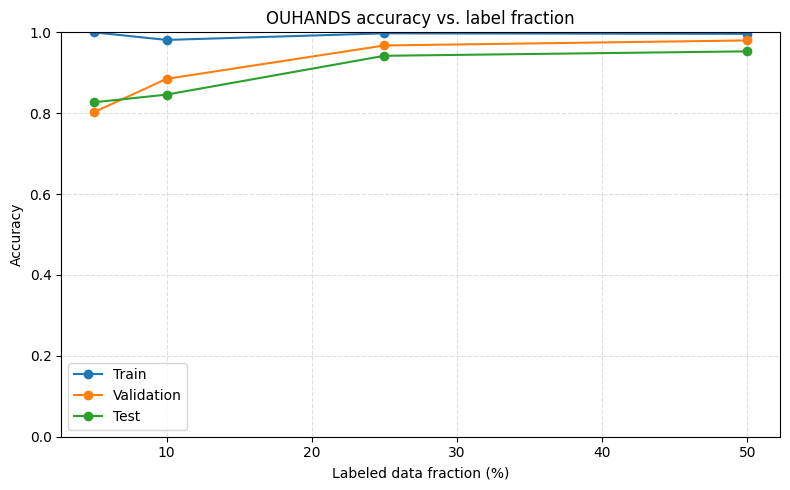

In [16]:
# Summaries and visuals
metrics_df = pd.DataFrame(metrics_summary).sort_values("fraction").reset_index(drop=True)
metrics_df["train_fraction_pct"] = metrics_df["fraction"] * 100
metrics_df["train_samples"] = (metrics_df["fraction"] * len(datasets_by_fraction[label_fractions[0]]["train"]) / label_fractions[0]).astype(int)


display(metrics_df[["train_fraction_pct", "train_samples","train_accuracy", "val_accuracy", "test_accuracy"]])

plt.figure(figsize=(8, 5))
plt.plot(metrics_df["train_fraction_pct"], metrics_df["train_accuracy"], marker="o", label="Train")
plt.plot(metrics_df["train_fraction_pct"], metrics_df["val_accuracy"], marker="o", label="Validation")
plt.plot(metrics_df["train_fraction_pct"], metrics_df["test_accuracy"], marker="o", label="Test")
plt.xlabel("Labeled data fraction (%)")
plt.ylabel("Accuracy")
plt.title("OUHANDS accuracy vs. label fraction")
plt.ylim(0, 1.0)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()